In [1]:
from datasets import load_dataset
from PIL import ImageDraw, Image
from torch.utils.data import default_collate
import numpy as np
from evaluate import load
from transformers import ViTFeatureExtractor, ViTModel, TrainingArguments, Trainer

Found cached dataset beans (C:/Users/Kevin/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

# Unit Check

In [2]:
ds = load_dataset('beans')
ex = ds['train'][400]
ex

{'image_file_path': 'C:\\Users\\Kevin\\.cache\\huggingface\\datasets\\downloads\\extracted\\0c08c0df28e72cf903074cf8a5423199131cd3c3bf5c7552d4a70a3bd8e8028a\\train\\bean_rust\\bean_rust_train.148.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 1}

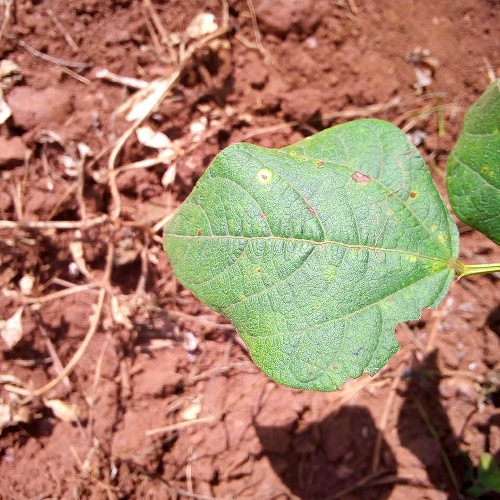

In [3]:
image = ex['image']
image

In [5]:
labels = ds['train'].features['labels']
labels.int2str(ex['labels'])

'bean_rust'

Loading cached processed dataset at C:/Users/Kevin/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-a6a943931a91a386.arrow
Loading cached processed dataset at C:/Users/Kevin/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-efcfba7212acefba.arrow
Loading cached processed dataset at C:/Users/Kevin/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-bacd7a5a541bc2bc.arrow


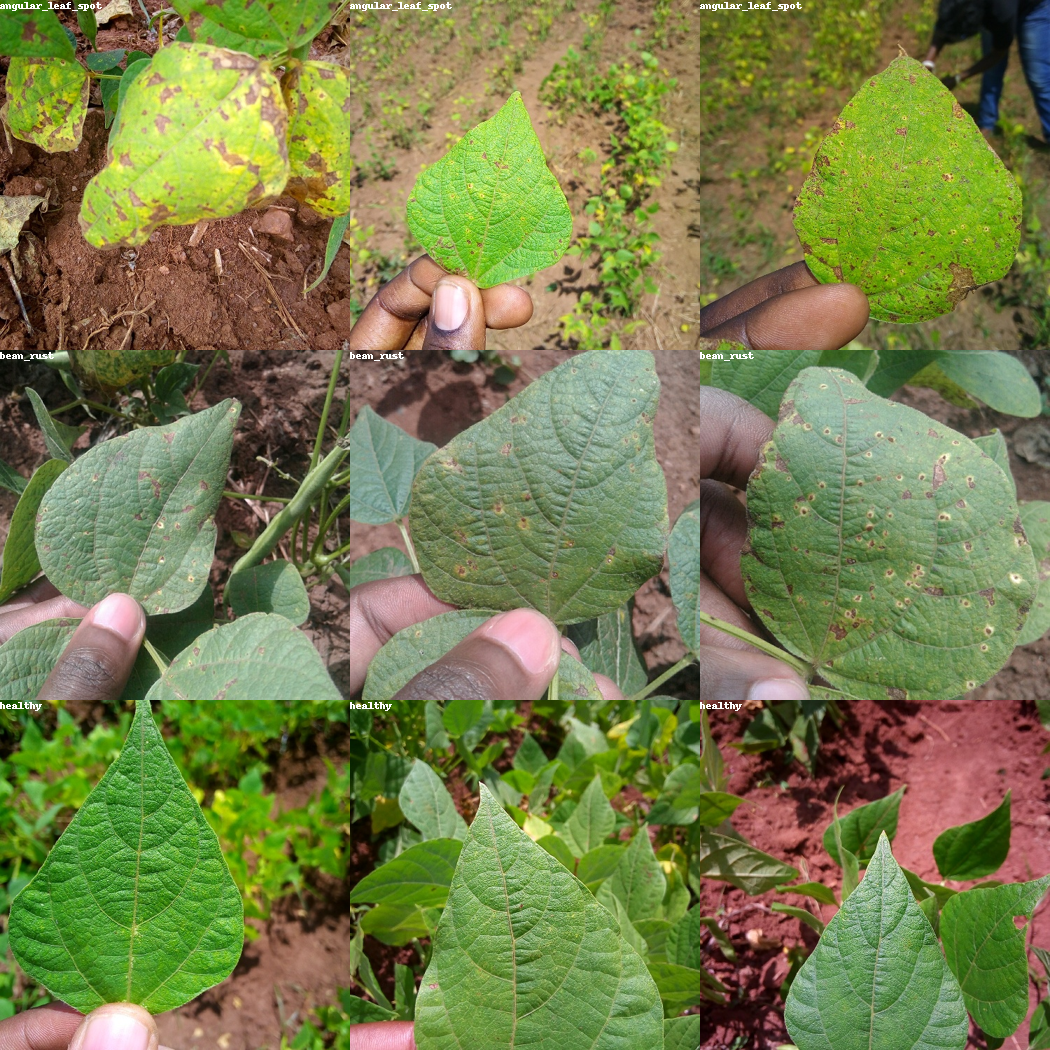

In [6]:
def show_examples(data, seed=42, examples_per_class=3, size=(350, 350)):
    w, h = size
    label_example = data.features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)

    for lid, label in enumerate(label_example):
        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = (
            ds['train']
            .filter(lambda x: x['labels'] == lid)
            .shuffle(seed)
            .select(range(examples_per_class))
        )

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            img = example['image']
            idx = examples_per_class * lid + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(img.resize(size), box=box)
            draw.text(box, label, (255, 255, 255))
    return grid


show_examples(ds['train'], examples_per_class=3)

# Model

In [7]:
def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['labels']
    return inputs

def compute_metrics(p):
    metric = load("accuracy")
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [9]:
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
prepared_ds = ds.with_transform(transform)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_22388\2425197347.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [29]:


labels = ds['train'].features['labels'].names

model = ViTModel.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

loading configuration file config.json from cache at C:\Users\Kevin/.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k\snapshots\1ba429d32753f33a0660b80ac6f43a3c80c18938\config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "angular_leaf_spot",
    "1": "bean_rust",
    "2": "healthy"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "angular_leaf_spot": "0",
    "bean_rust": "1",
    "healthy": "2"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.24.0"
}

loading weights file pytorch_model.bin from cache at C:\Users\Kevin/.cache

In [13]:
training_args = TrainingArguments(
  output_dir="./vit_beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=default_collate,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [15]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

C:\Users\Kevin\miniconda3\envs\nlp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 260
  Number of trainable parameters = 85800963


Step,Training Loss,Validation Loss,Accuracy
100,0.199700,0.045613,0.992481
200,0.023800,0.043949,0.984962


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5\checkpoint-100
Configuration saved in ./vit-base-beans-demo-v5\checkpoint-100\config.json
Model weights saved in ./vit-base-beans-demo-v5\checkpoint-100\pytorch_model.bin
Feature extractor saved in ./vit-base-beans-demo-v5\checkpoint-100\preprocessor_config.json
***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5\checkpoint-200
Configuration saved in ./vit-base-beans-demo-v5\checkpoint-200\config.json
Model weights saved in ./vit-base-beans-demo-v5\checkpoint-200\pytorch_model.bin
Feature extractor saved in ./vit-base-beans-demo-v5\checkpoint-200\preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit-base-beans-demo-v5\checkpoint-200 (score: 0.04394858703017235).
Saving model checkpoint to ./vit-base-beans-demo-v5


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1235
  train_runtime            =  0:01:03.91
  train_samples_per_second =       64.71
  train_steps_per_second   =       4.068


In [16]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.985
  eval_loss               =     0.0439
  eval_runtime            = 0:00:01.08
  eval_samples_per_second =    122.998
  eval_steps_per_second   =     15.722
